In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
import matplotlib.pyplot as plt
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import math

In [2]:
base_url = "https://nextspaceflight.com/launches/past/"
last_page = 5

In [3]:
options = Options()
options.add_argument("--headless=new")
browser = webdriver.Chrome(options=options)

launch_data = []
for page in range(1, last_page + 1):
    browser.get(f"{base_url}?page={page}")
    cards = browser.find_elements(By.CLASS_NAME, "mdl-card")
    for card in cards:
        company = card.find_element(By.CLASS_NAME, "mdl-card__title-text").text
        rocket_and_payload = card.find_element(By.CLASS_NAME, "header-style").text
        date_and_location = card.find_element(By.CLASS_NAME, "mdl-card__supporting-text").text
        details_url = card.find_element(By.CLASS_NAME, "mdc-button").get_attribute("href")
        border_color = card.value_of_css_property("border-top-color")

        if "rgba(69, 207, 93, 1)" == border_color:
            successful = "1" #Exito
        else:
            successful = "0" #Fracaso

        launch_dict = {
            'company': company,
            'rocket_and_payload': rocket_and_payload,
            'date_and_location': date_and_location,
            'details_url': details_url,
            'successful': successful
        }
        launch_data.append(launch_dict)
browser.quit()

df = pd.DataFrame(launch_data, columns=['company', 'rocket_and_payload', 'date_and_location', 'details_url', 'successful'])

In [4]:
browser = webdriver.Chrome(options=options)
wait = WebDriverWait(browser, 10)


prices = []
leo_weights = []  
gto_weights = []  
rocket_heights = []
fairing_diameters = []
fairing_heights = []

for index in range(len(df.details_url)):
    print(f"Processing launch {index + 1}/{len(df.details_url)}")#pensar en quitar
    browser.get(df.details_url[index])

    details_els = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "mdl-card__supporting-text")))
    details_texts = [el.text for el in details_els]

    price = 0.0
    leo_weight = 0
    gto_weight = 0
    rocket_h = 0.0
    fairing_d = 0.0
    fairing_h = 0.0

    if len(details_texts) > 1:
        parts = details_texts[1].split("\n")
        for part in parts:
            if "Price: " in part:
                price = part.replace("Price: $", "").replace(" million", "").strip()
                price = float(price)
            elif "Payload to LEO:" in part:
                leo_weight = part.replace("Payload to LEO:", "").replace("kg", "").strip()
                leo_weight = int(leo_weight.replace(',', ''))
            elif "Payload to GTO:" in part:
                gto_weight = part.replace("Payload to GTO:", "").replace("kg", "").strip()
                gto_weight = int(gto_weight.replace(',', ''))
            elif "Rocket Height:" in part:  
                rocket_h = part.replace("Rocket Height:", "").replace("m", "").strip()
                rocket_h = float(rocket_h)
            elif "Fairing Diameter:" in part:
                fairing_d = part.replace("Fairing Diameter:", "").replace("m", "").strip()
                fairing_d = float(fairing_d)
            elif "Fairing Height:" in part:
                fairing_h = part.replace("Fairing Height:", "").replace("m", "").strip()
                fairing_h = float(fairing_h)

   
    prices.append(price)
    leo_weights.append(leo_weight)
    gto_weights.append(gto_weight)
    rocket_heights.append(rocket_h)
    fairing_diameters.append(fairing_d)
    fairing_heights.append(fairing_h)

browser.quit()


df["price_million"] = prices
df["leo_weight_kg"] = leo_weights
df["gto_weight_kg"] = gto_weights
df["total_payload_kg"] = df["leo_weight_kg"] + df["gto_weight_kg"]
df["rocket_height_m"] = rocket_heights
df["fairing_diameter_m"] = fairing_diameters
df["fairing_height_m"] = fairing_heights

df

Processing launch 1/150
Processing launch 2/150
Processing launch 3/150
Processing launch 4/150
Processing launch 5/150
Processing launch 6/150
Processing launch 7/150
Processing launch 8/150
Processing launch 9/150
Processing launch 10/150
Processing launch 11/150
Processing launch 12/150
Processing launch 13/150
Processing launch 14/150
Processing launch 15/150
Processing launch 16/150
Processing launch 17/150
Processing launch 18/150
Processing launch 19/150
Processing launch 20/150
Processing launch 21/150
Processing launch 22/150
Processing launch 23/150
Processing launch 24/150
Processing launch 25/150
Processing launch 26/150
Processing launch 27/150
Processing launch 28/150
Processing launch 29/150
Processing launch 30/150
Processing launch 31/150
Processing launch 32/150
Processing launch 33/150
Processing launch 34/150
Processing launch 35/150
Processing launch 36/150
Processing launch 37/150
Processing launch 38/150
Processing launch 39/150
Processing launch 40/150
Processin

,company,rocket_and_payload,date_and_location,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m
0,SpaceX,Falcon 9 Block 5 | Nusantara Lima,"Thu Sep 11, 2025 22:56 CLST\nSLC-40, Cape Cana...",https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.000
1,Roscosmos,Soyuz 2.1a | Progress MS-32,"Thu Sep 11, 2025 12:54 CLST\nSite 31/6, Baikon...",https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.590
2,SpaceX,Falcon 9 Block 5 | Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 CLST\nSLC-4E, Vandenber...",https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.000
3,CASC,Long March 7A | Yaogan 45,"Mon Sep 8, 2025 23:00 CLST\nLC-201, Wenchang S...",https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.400
4,Chinarocket,Jielong 3 | Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 CLST\nOriental Spaceport...",https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
145,SpaceX,Falcon 9 Block 5 | Starlink Group 6-72,"Sat Apr 5, 2025 11:07 PM CLT\nSLC-40, Cape Can...",https://nextspaceflight.com/launches/details/7817,1,69.75,22800,8300,31100,70.00,5.20,13.000
146,SpaceX,Falcon 9 Block 5 | Starlink Group 11-13,"Thu Apr 3, 2025 22:02 CLST\nSLC-4E, Vandenberg...",https://nextspaceflight.com/launches/details/7808,1,69.75,22800,8300,31100,70.00,5.20,13.000
147,CASC,Long March 6 | Tianping-3A-02,"Wed Apr 2, 2025 23:12 CLST\nLC-16, Taiyuan Sat...",https://nextspaceflight.com/launches/details/7815,1,19.00,1080,0,1080,29.24,2.60,6.145
148,CASC,Long March 2D | 4 x SatNet test satellites,"Tue Apr 1, 2025 01:00 CLST\nSite 9401 (SLS-2),...",https://nextspaceflight.com/launches/details/7813,1,29.75,3500,1200,4700,40.77,3.35,7.820


In [5]:
df.size
df.shape

(150, 12)

In [6]:
df["rocket"] = df["rocket_and_payload"].str.split("|").str[0]
df["payload"] = df["rocket_and_payload"].str.split("|").str[1]
df["date"] = df["date_and_location"].str.split("\n").str[0]
df["location"] = df["date_and_location"].str.split("\n").str[1]
df.drop(columns=["rocket_and_payload", "date_and_location"], inplace=True)
df

,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,date,location
0,SpaceX,https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Nusantara Lima,"Thu Sep 11, 2025 22:56 CLST","SLC-40, Cape Canaveral SFS, Florida, USA"
1,Roscosmos,https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.590,Soyuz 2.1a,Progress MS-32,"Thu Sep 11, 2025 12:54 CLST","Site 31/6, Baikonur Cosmodrome, Kazakhstan"
2,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 CLST","SLC-4E, Vandenberg SFB, California, USA"
3,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.400,Long March 7A,Yaogan 45,"Mon Sep 8, 2025 23:00 CLST","LC-201, Wenchang Space Launch Site, China"
4,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.000,Jielong 3,Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 CLST","Oriental Spaceport Launch Ship (Area 1), China..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SpaceX,https://nextspaceflight.com/launches/details/7817,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Starlink Group 6-72,"Sat Apr 5, 2025 11:07 PM CLT","SLC-40, Cape Canaveral SFS, Florida, USA"
146,SpaceX,https://nextspaceflight.com/launches/details/7808,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Starlink Group 11-13,"Thu Apr 3, 2025 22:02 CLST","SLC-4E, Vandenberg SFB, California, USA"
147,CASC,https://nextspaceflight.com/launches/details/7815,1,19.00,1080,0,1080,29.24,2.60,6.145,Long March 6,Tianping-3A-02,"Wed Apr 2, 2025 23:12 CLST","LC-16, Taiyuan Satellite Launch Center, China"
148,CASC,https://nextspaceflight.com/launches/details/7813,1,29.75,3500,1200,4700,40.77,3.35,7.820,Long March 2D,4 x SatNet test satellites,"Tue Apr 1, 2025 01:00 CLST","Site 9401 (SLS-2), Jiuquan Satellite Launch Ce..."


In [7]:
def clean_date(scraped_date_string):
    months = {"Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05", "Jun":"06",
              "Jul":"07", "Aug":"08", "Sep":"09", "Oct":"10", "Nov":"11", "Dec":"12"}
    parts = scraped_date_string.split(" ")
    month = parts[1]
    day = parts[2].replace(",", "")
    year = parts[3]
    return f"{year}/{months[month]}/{day}"

In [8]:
df["cleaned_date"] = df["date"].apply(clean_date)
df["year"] = df["cleaned_date"].str.split("/").str[0]
df["month"] = df["cleaned_date"].str.split("/").str[1]
df["day"] = df["cleaned_date"].str.split("/").str[2]
df.drop(columns=["date", "cleaned_date"], inplace=True)
df

,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,location,year,month,day
0,SpaceX,https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Nusantara Lima,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,11
1,Roscosmos,https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.590,Soyuz 2.1a,Progress MS-32,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",2025,09,11
2,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Tranche 1 Transport Layer B,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10
3,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.400,Long March 7A,Yaogan 45,"LC-201, Wenchang Space Launch Site, China",2025,09,8
4,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.000,Jielong 3,Geely Constellation Group 05,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SpaceX,https://nextspaceflight.com/launches/details/7817,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Starlink Group 6-72,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,04,5
146,SpaceX,https://nextspaceflight.com/launches/details/7808,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Starlink Group 11-13,"SLC-4E, Vandenberg SFB, California, USA",2025,04,3
147,CASC,https://nextspaceflight.com/launches/details/7815,1,19.00,1080,0,1080,29.24,2.60,6.145,Long March 6,Tianping-3A-02,"LC-16, Taiyuan Satellite Launch Center, China",2025,04,2
148,CASC,https://nextspaceflight.com/launches/details/7813,1,29.75,3500,1200,4700,40.77,3.35,7.820,Long March 2D,4 x SatNet test satellites,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2025,04,1


In [9]:
rocket_volume = math.pi * (df["fairing_diameter_m"] / 2) ** 2 * df["rocket_height_m"]
fairing_volume = math.pi * (df["fairing_diameter_m"] / 2) ** 2 * df["fairing_height_m"] * (1/3)
df["volume_total_m3"] = round((rocket_volume + fairing_volume), 2)
df


,company,details_url,successful,price_million,leo_weight_kg,gto_weight_kg,total_payload_kg,rocket_height_m,fairing_diameter_m,fairing_height_m,rocket,payload,location,year,month,day,volume_total_m3
0,SpaceX,https://nextspaceflight.com/launches/details/6907,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Nusantara Lima,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,09,11,1578.63
1,Roscosmos,https://nextspaceflight.com/launches/details/7710,1,17.42,7500,0,7500,51.38,4.11,15.590,Soyuz 2.1a,Progress MS-32,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",2025,09,11,750.60
2,SpaceX,https://nextspaceflight.com/launches/details/7219,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Tranche 1 Transport Layer B,"SLC-4E, Vandenberg SFB, California, USA",2025,09,10,1578.63
3,CASC,https://nextspaceflight.com/launches/details/7943,1,0.00,12000,7000,19000,58.00,4.20,12.400,Long March 7A,Yaogan 45,"LC-201, Wenchang Space Launch Site, China",2025,09,8,860.82
4,Chinarocket,https://nextspaceflight.com/launches/details/7942,1,0.00,1500,0,1500,31.00,3.35,0.000,Jielong 3,Geely Constellation Group 05,"Oriental Spaceport Launch Ship (Area 1), China...",2025,09,8,273.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SpaceX,https://nextspaceflight.com/launches/details/7817,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Starlink Group 6-72,"SLC-40, Cape Canaveral SFS, Florida, USA",2025,04,5,1578.63
146,SpaceX,https://nextspaceflight.com/launches/details/7808,1,69.75,22800,8300,31100,70.00,5.20,13.000,Falcon 9 Block 5,Starlink Group 11-13,"SLC-4E, Vandenberg SFB, California, USA",2025,04,3,1578.63
147,CASC,https://nextspaceflight.com/launches/details/7815,1,19.00,1080,0,1080,29.24,2.60,6.145,Long March 6,Tianping-3A-02,"LC-16, Taiyuan Satellite Launch Center, China",2025,04,2,166.12
148,CASC,https://nextspaceflight.com/launches/details/7813,1,29.75,3500,1200,4700,40.77,3.35,7.820,Long March 2D,4 x SatNet test satellites,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2025,04,1,382.33


In [10]:
df.to_csv('launches.csv', index=False)

### Visualización de datos

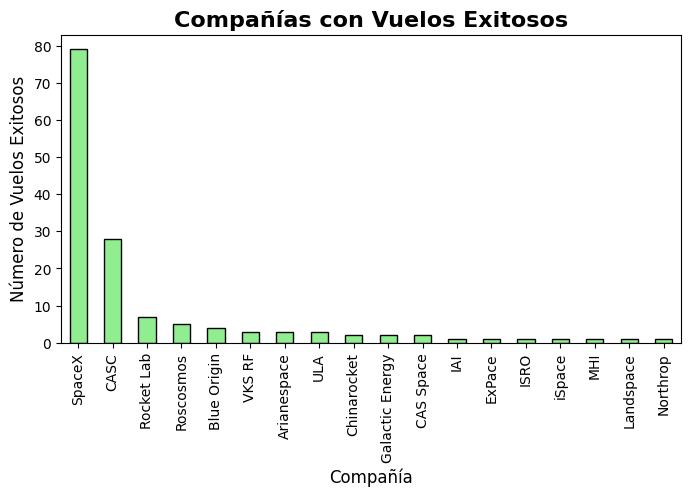


Vuelos exitosos por compañia:
company
SpaceX             79
CASC               28
Rocket Lab          7
Roscosmos           5
Blue Origin         4
VKS RF              3
Arianespace         3
ULA                 3
Chinarocket         2
Galactic Energy     2
CAS Space           2
IAI                 1
ExPace              1
ISRO                1
iSpace              1
MHI                 1
Landspace           1
Northrop            1
Name: count, dtype: int64


In [11]:
#Vuelos exitosos por compañia

df_successful = df[df['successful'] == '1']

company_successful = df_successful['company'].value_counts()

plt.figure(figsize=(8, 4))
company_successful.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Compañías con Vuelos Exitosos', fontsize=16, fontweight='bold')
plt.xlabel('Compañía', fontsize=12)
plt.ylabel('Número de Vuelos Exitosos', fontsize=12)
plt.show()

print("\nVuelos exitosos por compañia:")
print(company_successful)

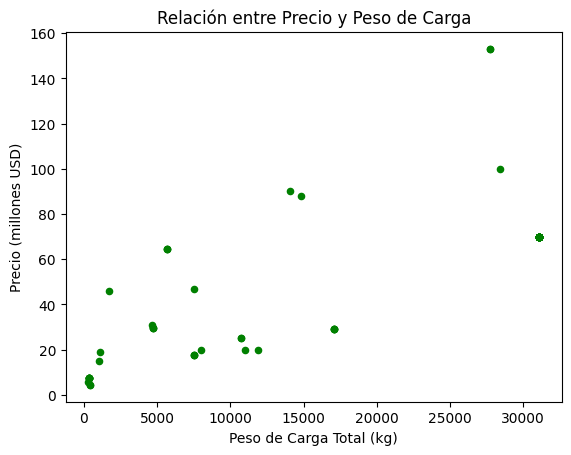

     price_million  total_payload_kg
126         153.00             27750
76          153.00             27750
79          100.00             28400
69           90.00             14100
35           88.00             14850
27           69.75             31100
13           69.75             31100
11           69.75             31100
14           69.75             31100
10           69.75             31100
18           69.75             31100
16           69.75             31100
20           69.75             31100
23           69.75             31100
22           69.75             31100
42           69.75             31100
31           69.75             31100
15           69.75             31100
0            69.75             31100
2            69.75             31100


In [12]:
# Relacion entre precio y peso de carga

df_valor_carga = df[['price_million', 'total_payload_kg']]
df_valor_carga = df_valor_carga[df_valor_carga['price_million'] > 0]

df_valor_carga.plot(kind='scatter', x='total_payload_kg', y='price_million', color='green')
plt.title('Relación entre Precio y Peso de Carga')
plt.xlabel('Peso de Carga Total (kg)')
plt.ylabel('Precio (millones USD)')
plt.show()

print(df_valor_carga.sort_values(by='price_million', ascending=False).head(20))

#Se puede ver en el grafico que no hay una relacion clara entre el peso de la carga y el precio del lanzamiento.
#Hay lanzamientos con cargas pequeñas que son muy caras y otros con cargas grandes que son mas baratos.
#Aunque podria haber una ligera tendencia a que a mayor peso, mayor precio, no es concluyente.

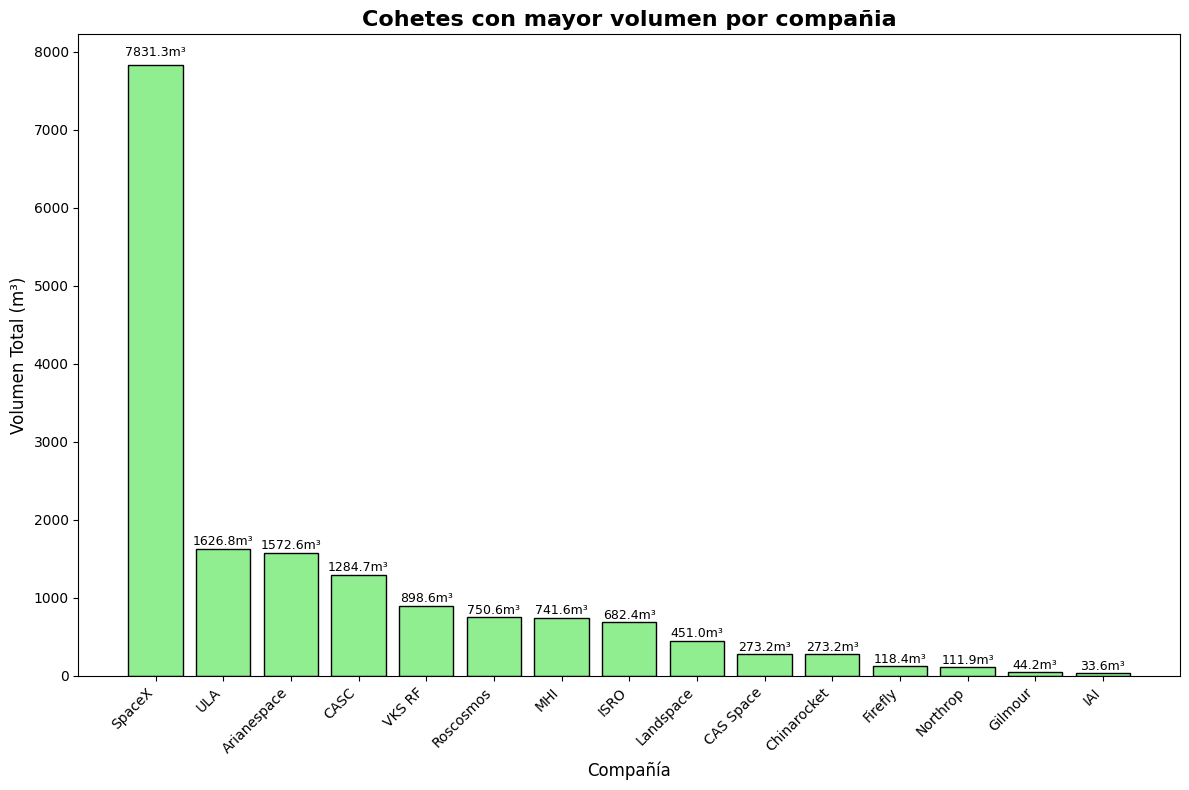

Top 15 compañias con cohetes mas grandes por volumen total:


,company,volume_total_m3
0,SpaceX,7831.28
1,ULA,1626.82
2,Arianespace,1572.62
3,CASC,1284.71
4,VKS RF,898.64
5,Roscosmos,750.60
6,MHI,741.57
7,ISRO,682.35
8,Landspace,450.99
9,CAS Space,273.24


In [13]:
# Empresas con cohetes más grandes por volumen total

df_big_rockets = df.groupby('company')['volume_total_m3'].max().sort_values(ascending=False)
df_big_rockets = df_big_rockets.rename("volume_total_m3").reset_index()

df_big_rockets_display = df_big_rockets[['company', 'volume_total_m3']].head(15)


plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(df_big_rockets_display)), df_big_rockets_display['volume_total_m3'], color='lightgreen', edgecolor='black')


plt.title('Cohetes con mayor volumen por compañia', fontsize=16, fontweight='bold')
plt.xlabel('Compañía', fontsize=12)
plt.ylabel('Volumen Total (m³)', fontsize=12)


labels = [row['company'] for _, row in df_big_rockets_display.iterrows()]
plt.xticks(range(len(df_big_rockets_display)), labels, rotation=45, ha='right', fontsize=10)


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{height:.1f}m³', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print('Top 15 compañias con cohetes mas grandes por volumen total:')
df_big_rockets_display

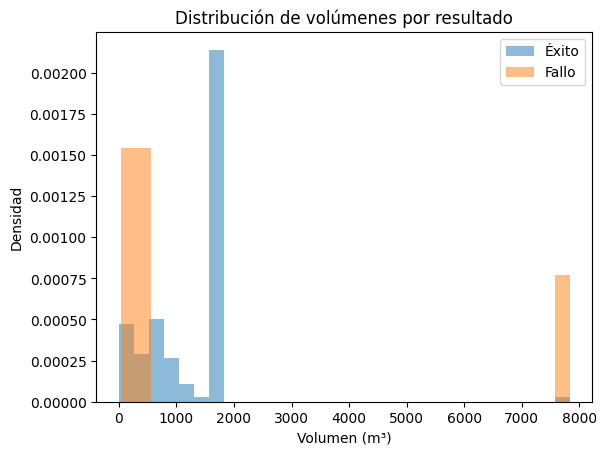

C:\Users\bruno\AppData\Local\Temp\ipykernel_1680\4091821435.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x_success.tolist(), x_fail.tolist()], labels=['Éxito', 'Fallo'], showfliers=True)


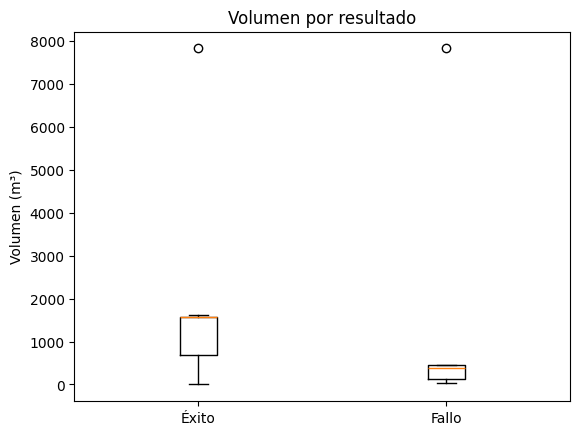

In [14]:

df2 = df.copy()

x_success = df2.loc[df2['successful'] == '1', 'volume_total_m3']
x_fail = df2.loc[df2['successful'] == '0', 'volume_total_m3']

plt.figure()
x_success.plot(kind='hist', bins=30, density=True, alpha=0.5, label='Éxito')
x_fail.plot(kind='hist',    bins=30, density=True, alpha=0.5, label='Fallo')
plt.xlabel('Volumen (m³)'); plt.ylabel('Densidad')
plt.title('Distribución de volúmenes por resultado'); plt.legend()
plt.show()

plt.figure()
plt.boxplot([x_success.tolist(), x_fail.tolist()], labels=['Éxito', 'Fallo'], showfliers=True)
plt.ylabel('Volumen (m³)')
plt.title('Volumen por resultado')
plt.show()

#Se puede observar que los cohetes al tener un volumen muy bajo o muy alto tienen mas probabilidad de fallar.

Analisis de resultados


In [15]:
#df country evolution 
df_ce = df[['company', 'successful', 'location', 'year', 'month', 'day']].copy()
df_ce['country'] = df_ce['location'].str.split(', ').str[-1]
df_ce['country'] = df_ce['country'].replace('China Coastal Waters', 'China')

In [16]:

df_ce['successful'] = df_ce['successful'].astype(int)

annual_country_stats = (df_ce.groupby(['year', 'country']).agg(total_launches=('successful', 'count'),successful_launches=('successful', 'sum')).reset_index())
#Tasa de exito anual por pais
annual_country_stats['success_rate_pct'] = (annual_country_stats['successful_launches'] / annual_country_stats['total_launches'] * 100).round(2)
print(annual_country_stats)


   year      country  total_launches  successful_launches  success_rate_pct
0  2025    Australia               1                    0              0.00
1  2025        China              38                   37             97.37
2  2025       France               3                    3            100.00
3  2025        India               2                    1             50.00
4  2025       Israel               1                    1            100.00
5  2025        Japan               1                    1            100.00
6  2025   Kazakhstan               4                    4            100.00
7  2025  New Zealand               7                    7            100.00
8  2025       Russia               4                    4            100.00
9  2025          USA              89                   87             97.75


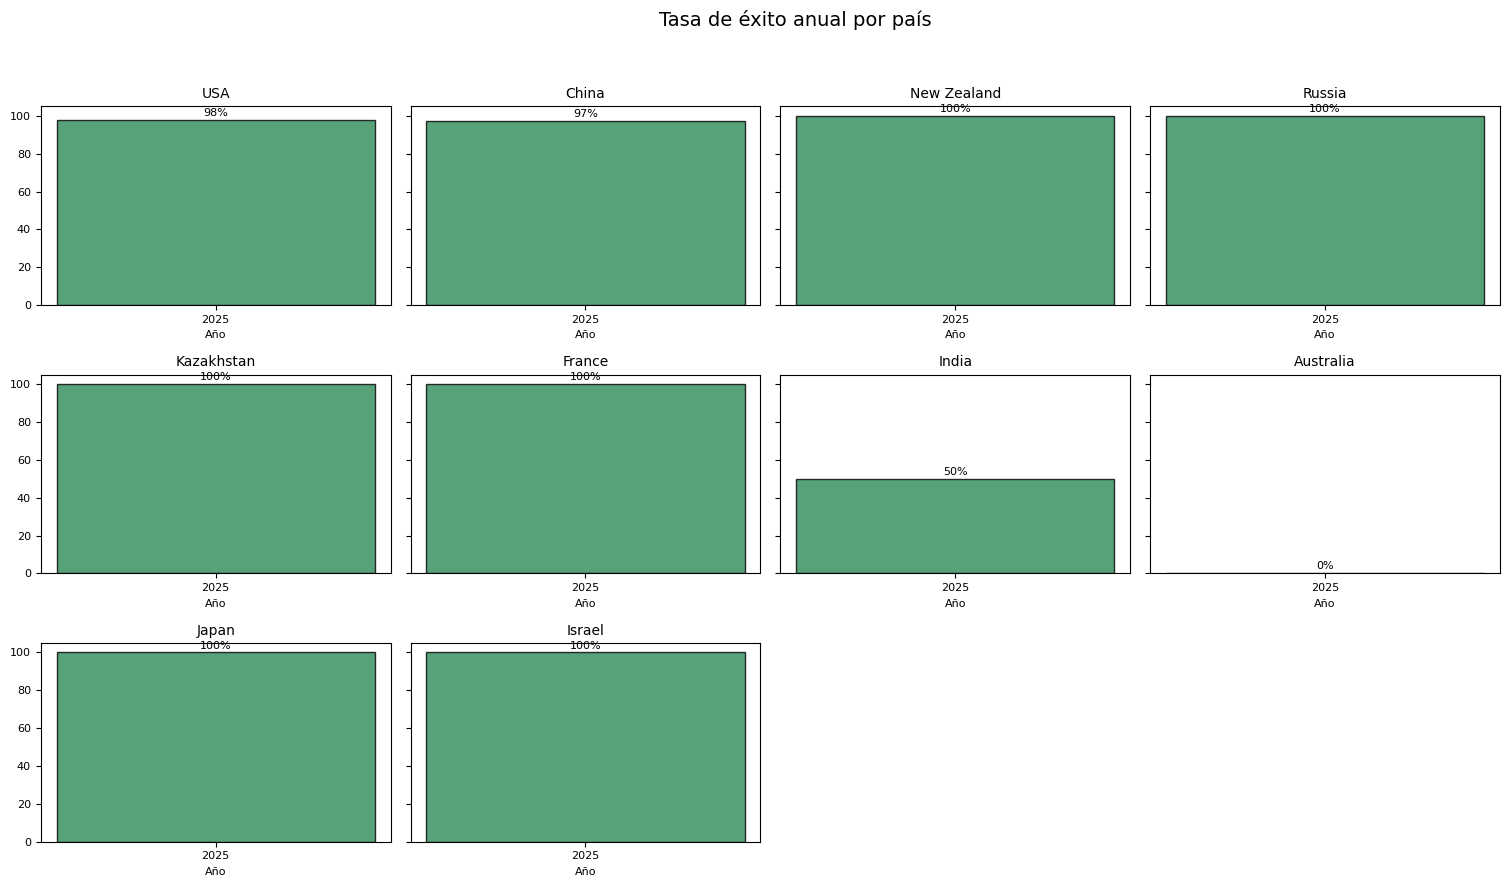

,year,country,total_launches,successful_launches,success_rate_pct
9,2025,USA,89,87,97.75
1,2025,China,38,37,97.37
7,2025,New Zealand,7,7,100.00
8,2025,Russia,4,4,100.00
6,2025,Kazakhstan,4,4,100.00
2,2025,France,3,3,100.00
3,2025,India,2,1,50.00
0,2025,Australia,1,0,0.00
5,2025,Japan,1,1,100.00
4,2025,Israel,1,1,100.00


In [17]:
country_order_rate = (annual_country_stats.groupby('country')['total_launches'].sum().sort_values(ascending=False).index.tolist())
annual_country_stats = annual_country_stats[annual_country_stats['country'].isin(country_order_rate)]
n_countries = len(country_order_rate)

cols = 4
rows = math.ceil(n_countries / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.0*rows), sharey=True)
axes = axes.flatten()

for i, country in enumerate(country_order_rate):
    ax = axes[i]
    sub = annual_country_stats[annual_country_stats['country'] == country].sort_values('year')

    ax.bar(sub['year'], sub['success_rate_pct'], color='seagreen', edgecolor='black', alpha=0.8)

    for x, y in zip(sub['year'], sub['success_rate_pct']):
        ax.text(x, y + 1, f"{y:.0f}%", ha='center', va='bottom', fontsize=8, color='black')

    ax.set_title(country, fontsize=10)
    ax.set_xlabel('Año', fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0, 105)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Tasa de éxito anual por país', fontsize=14)
fig.tight_layout(rect=(0,0,0.95,0.95))
plt.show()

annual_country_stats.sort_values(['total_launches'], ascending=[False])

Promps utilizados

para que sirve el .replace en Python
y el .strip()?
como puedo separar este texto Thu Sep 18, 2025 06:30 CLST
SLC-40, Cape Canaveral SFS, Florida, USA  para obtener por un lado Thu Sep 18, 2025 06:30 y por otro lado CLST
SLC-40, Cape Canaveral SFS, Florida, USA 

si tengo un data frame y hay muchas compañias de cohetes pero yo solo quiero contar los que tienen succesful "1" para ponerlo en un grafico donde se muestren las compañias con el mayor numero de vuelos exitosos ¿como podria hacerlo? 

tengo un dataframe en el cual se encuentran varios datos, pero necesito hacer un grafico de los valores de price y total payload to kg, como puedo extraer estos dos datos y colocarlos en un grafico en python ?

se puede hacer sin numpy, solo con panda y matpltlib?

si funciona pero queda una columna sin nombre, como puedo hacer para que quede algo ahi